In [30]:
import pandas as pd
import json
import os
import snowflake.snowpark.functions as F
from snowflake.snowpark import Session
from dotenv import load_dotenv
from snowflake.connector.pandas_tools import write_pandas
import snowflake.connector
from snowflake.snowpark import Session
import numpy as np

In [31]:
# load_dotenv(".env")
# conn = snowflake.connector.connect(
#     user=os.getenv("SNOWFLAKE_USER"),
#     password=os.getenv("SNOWFLAKE_PASSWORD"),
#     account=os.getenv("SNOWFLAKE_ACCOUNT"),
#     warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
#     database=os.getenv("SNOWFLAKE_DATABASE"),
#     schema=os.getenv("SNOWFLAKE_SCHEMA"),
#     role =os.getenv("SNOWFLAKE_ROLE")
# )

In [32]:
import os
connection_parameters = {
    "user": os.getenv("SNOWFLAKE_USER"),
    "password": os.getenv("SNOWFLAKE_PASSWORD"),
    "account": os.getenv("SNOWFLAKE_ACCOUNT"),
    "warehouse": os.getenv("SNOWFLAKE_WAREHOUSE"),
    "database": os.getenv("SNOWFLAKE_DATABASE"),
    "schema": os.getenv("SNOWFLAKE_SCHEMA"),
    "role": os.getenv("SNOWFLAKE_ROLE")
}


In [33]:
session = Session.builder.configs(connection_parameters).create()

In [34]:
df = session.table("DATAPICTURE")

In [35]:
df_pandas =df.toPandas()
df_pandas.head()

,column0,column1,column2,column3,column4,column5,column6,column7,column8,column9,...,column9991,column9992,column9993,column9994,column9995,column9996,column9997,column9998,column9999,Gender
0,0.752941,0.741176,0.725490,0.721569,0.729412,0.737255,0.737255,0.729412,0.729412,0.733333,...,0.388235,0.352941,0.341176,0.329412,0.356863,0.400000,0.419608,0.411765,0.400000,Male
1,0.592157,0.862745,0.913725,0.913725,0.913725,0.925490,0.921569,0.921569,0.925490,0.925490,...,0.180392,0.356863,0.266667,0.196078,0.219608,0.227451,0.207843,0.196078,0.227451,Female
2,0.917647,0.929412,0.909804,0.941176,0.917647,0.925490,0.917647,0.913725,0.909804,0.917647,...,0.133333,0.286275,0.596078,0.223529,0.156863,0.231373,0.250980,0.250980,0.250980,Male
3,0.768627,0.768627,0.768627,0.768627,0.772549,0.772549,0.772549,0.776471,0.776471,0.776471,...,0.611765,0.572549,0.490196,0.411765,0.454902,0.431373,0.411765,0.403922,0.403922,Female
4,0.458824,0.478431,0.847059,0.894118,0.886275,0.890196,0.819608,0.501961,0.450980,0.450980,...,0.407843,0.403922,0.400000,0.403922,0.396078,0.400000,0.400000,0.400000,0.400000,Female


In [36]:
df_pandas.columns

Index(['column0', 'column1', 'column2', 'column3', 'column4', 'column5',
       'column6', 'column7', 'column8', 'column9',
       ...
       'column9991', 'column9992', 'column9993', 'column9994', 'column9995',
       'column9996', 'column9997', 'column9998', 'column9999', 'Gender'],
      dtype='object', length=10001)

In [42]:
values =df_pandas.drop(["Gender"],axis=1).values

In [43]:
mean_value = np.mean(values, axis=0)

In [44]:
mean_value.shape

(10000,)

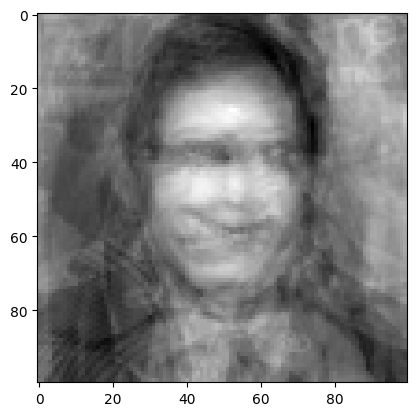

In [45]:
import matplotlib.pyplot as plt
plt.imshow(mean_value.reshape(100, 100),cmap='gray')

In [46]:
value_clean = values - mean_value

# **PCA**

In [47]:
import numpy as np
from sklearn.decomposition import PCA

In [48]:
pca =PCA(n_components=None, whiten=True, svd_solver='auto')
pca.fit(value_clean)

PCA(whiten=True)

In [49]:
exp_df = pd.DataFrame({
    "explained_var": pca.explained_variance_ratio_,
    "cum_explained_var": pca.explained_variance_ratio_.cumsum(),
    "eigen_value": pca.explained_variance_,
    "pricipal_components": np.arange(1, len(pca.explained_variance_ratio_) + 1)
})

In [50]:
exp_df.head()

,explained_var,cum_explained_var,eigen_value,pricipal_components
0,0.332593,0.332593,239.321667,1
1,0.131658,0.464251,94.736261,2
2,0.093295,0.557546,67.131780,3
3,0.075076,0.632622,54.021563,4
4,0.063387,0.696008,45.610670,5


In [51]:
exp_df.tail()

,explained_var,cum_explained_var,eigen_value,pricipal_components
14,1.410977e-02,0.969128,1.015287e+01,15
15,1.185576e-02,0.980984,8.530968e+00,16
16,9.934887e-03,0.990919,7.148778e+00,17
17,9.080889e-03,1.000000,6.534273e+00,18
18,5.642448e-32,1.000000,4.060097e-29,19


In [52]:
exp_df.set_index("pricipal_components", inplace=True)

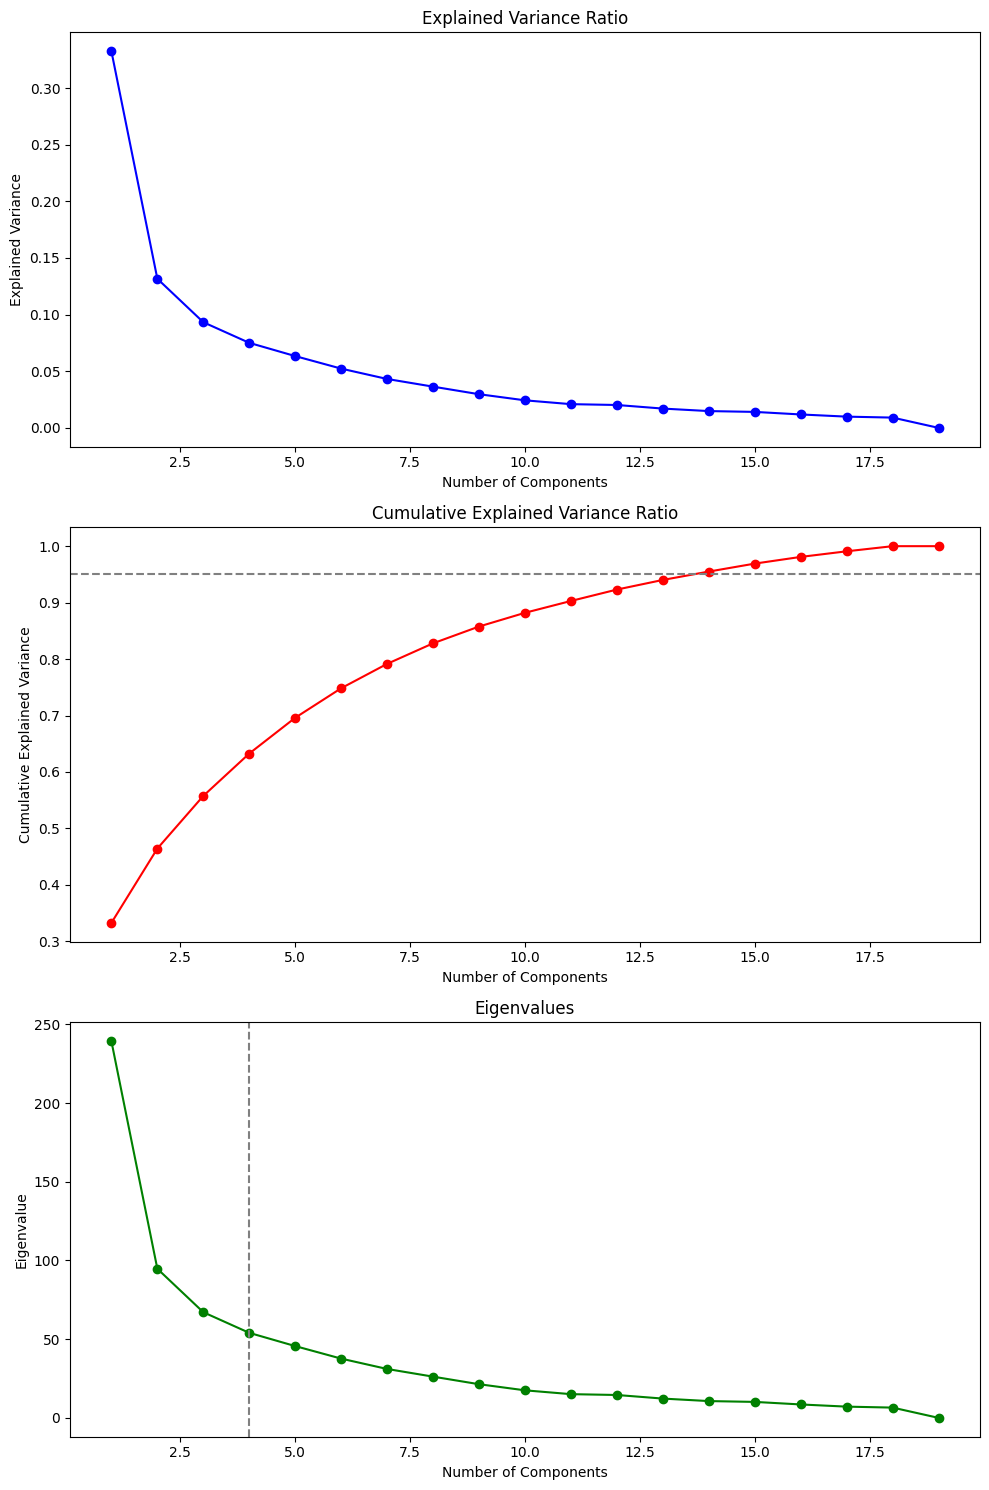

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(10, 15))
ax[0].plot(exp_df["explained_var"], marker='o', linestyle='-', color='b')
ax[0].set_title('Explained Variance Ratio')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Explained Variance')


ax[1].plot(exp_df["cum_explained_var"], marker='o', linestyle='-', color='r')
ax[1].set_title('Cumulative Explained Variance Ratio')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')

ax[1].axhline(y=0.95, color='gray', linestyle='--')

ax[2].plot(exp_df["eigen_value"], marker='o', linestyle='-', color='g')
ax[2].set_title('Eigenvalues')
ax[2].set_xlabel('Number of Components')
ax[2].set_ylabel('Eigenvalue')

ax[2].axvline(x=4, color='gray', linestyle='--')

plt.tight_layout()
plt.show()


In [ ]:
# n_components = exp_df.shape[0] // 2
# pca_100 = PCA(n_components=n_components, whiten=True, svd_solver='auto')
# pca_data = pca_100.fit_transform(value_clean)


# **Saving models and data**

In [53]:
from sklearn.decomposition import PCA

desired_cum_explained_variance = 0.95
cum_explained_variance = pca.explained_variance_ratio_.cumsum()
n_components_optimal = np.argmax(cum_explained_variance >= desired_cum_explained_variance) + 1


In [54]:
pca_optimal = PCA(n_components=n_components_optimal, whiten=True, svd_solver='auto')
pca_data_optimal = pca_optimal.fit_transform(value_clean)

In [58]:
import mlflow
mlflow.set_tracking_uri("http://mlflow_server:5000")
mlflow.set_experiment("Face ML")
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 0.0.0.0 -p 5000


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1726425399372, experiment_id='1', last_update_time=1726425399372, lifecycle_stage='active', name='Face ML', tags={}>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create the DataFrame as before
exp_df = pd.DataFrame({ 
    "explained_var": pca.explained_variance_ratio_,
    "cum_explained_var": pca.explained_variance_ratio_.cumsum(),
    "eigen_value": pca.explained_variance_,
    "principal_components": np.arange(1, len(pca.explained_variance_ratio_) + 1)
})

# Plotting
fig, ax = plt.subplots(nrows=3, figsize=(10, 15))

# Explained Variance Ratio
ax[0].plot(exp_df["principal_components"], exp_df["explained_var"], marker='o', linestyle='-', color='b')
ax[0].set_title('Explained Variance Ratio')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Explained Variance')


ax[1].plot(exp_df["principal_components"], exp_df["cum_explained_var"], marker='o', linestyle='-', color='r')
ax[1].set_title('Cumulative Explained Variance Ratio')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].axhline(y=desired_cum_explained_variance, color='gray', linestyle='--')


ax[2].plot(exp_df["principal_components"], exp_df["eigen_value"], marker='o', linestyle='-', color='g')
ax[2].set_title('Eigenvalues')
ax[2].set_xlabel('Number of Components')
ax[2].set_ylabel('Eigenvalue')
ax[2].axvline(x=n_components_optimal, color='gray', linestyle='--')

plt.tight_layout()


plot_path = "pca_analysis_plots.png"
plt.savefig(plot_path)
plt.close()


In [ ]:
with mlflow.start_run():
    mlflow.sklearn.log_model(pca_optimal, "pca_model_optimal")
    mlflow.log_param("n_components_optimal", n_components_optimal)
    mlflow.log_param("desired_cum_explained_variance", desired_cum_explained_variance)
    mlflow.log_param("whiten", pca_optimal.whiten)
    mlflow.log_param("svd_solver", pca_optimal.svd_solver)
    mlflow.log_metric("cum_explained_variance_optimal", cum_explained_variance[n_components_optimal - 1])
    mlflow.log_artifact(plot_path)
    exp_df.to_csv("pca_explained_variance.csv", index=False)
    mlflow.log_artifact("pca_explained_variance.csv")


2024/09/15 18:42:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/09/15 18:42:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/15 18:42:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-wren-30 at: http://mlflow_server:5000/#/experiments/1/runs/a96af212397749d680e813f189f5d1a5.
2024/09/15 18:42:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow_server:5000/#/experiments/1.


### Save data in Snowpark 

In [ ]:
import pandas as pd
import json
import os
import snowflake.snowpark.functions as F
from snowflake.snowpark import Session
from dotenv import load_dotenv
from snowflake.connector.pandas_tools import write_pandas
import snowflake.connector

load_dotenv(".env")

In [ ]:
conn = snowflake.connector.connect(
    user=os.getenv("SNOWFLAKE_USER"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    warehouse=os.getenv("SNOWFLAKE_WAREHOUSE"),
    database=os.getenv("SNOWFLAKE_DATABASE"),
    schema=os.getenv("SNOWFLAKE_SCHEMA"),
    role=os.getenv("SNOWFLAKE_ROLE")
)

In [64]:
pca_columns = [f'PC{i+1}' for i in range(pca_data_optimal.shape[1])]
pca_df = pd.DataFrame(pca_data_optimal, columns=pca_columns)
pca_df['Gender'] = target.values 

In [65]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Gender
0,0.781725,-1.083166,2.068510,-0.459759,0.946967,-0.375950,-2.235528,0.486563,1.033063,-0.651369,-0.159774,-0.154207,0.760730,-1.447432,Male
1,0.360205,0.192787,-0.246103,-1.938841,1.736041,0.255633,1.344490,0.464934,-0.087306,1.453282,-1.952516,-0.167196,1.134320,0.355482,Female
2,1.602139,-0.600222,-0.767696,0.707317,-1.982304,-0.901762,0.051910,-0.766384,0.735046,0.044589,-1.638914,-0.966147,0.348873,-0.119167,Male
3,0.988254,0.740282,0.567556,1.034366,-0.462661,0.478486,-0.459878,0.467084,0.632484,0.288417,-0.750558,0.423497,0.176144,1.677601,Female
4,-0.814652,-0.459478,-0.593204,-0.556578,-1.434732,0.002591,-1.370156,1.026063,-2.087497,1.675063,0.079678,-1.164776,-0.413463,-0.776033,Female


In [66]:
table_name ='CLEANDATA'
try:
    session.write_pandas(
        pca_df,
        table_name=table_name,
        auto_create_table=True,        
        overwrite=True,                  
        quote_identifiers=False       
    )
    print(f"Data successfully uploaded to Snowflake table '{table_name}'.")
except Exception as e:
    print(f"An error occurred while uploading to Snowflake: {e}")
finally:
    # Close the Snowflake session
    session.close()
    print("Snowflake session closed.")

Data successfully uploaded to Snowflake table 'CLEANDATA'.
Snowflake session closed.
